In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np

%matplotlib inline

In [ ]:
dataset = MNIST(root='data/', download=True)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
len(dataset)

60000

In [ ]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

9


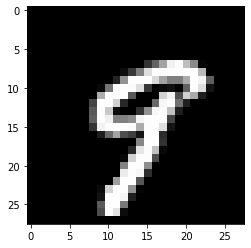

In [ ]:
img, label = dataset[5523]
plt.imshow(img, cmap='gray')
print(label)

In [ ]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, 'Label:', label)

torch.Size([1, 28, 28]) Label: 5


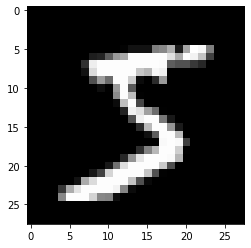

In [ ]:
plt.imshow(img_tensor.permute([1, 2, 0]).reshape([28, 28]), cmap='gray')

In [ ]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [ ]:
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 100
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, 2*batch_size)

In [ ]:
input_size = 28*28
hidden_size = 128
output_size = 10

In [ ]:
def accuracy(output, labels):
  _, preds = torch.max(output, dim=1)
  accu = torch.tensor(torch.sum(preds == labels)) / len(labels)
  return accu

In [ ]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(nn.Linear(input_size, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, out_features=output_size),
                                nn.Softmax())
  
  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    output = self.linear(xb)
    return output

  def training_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.cross_entropy(output, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    output = self(images)
    loss = F.cross_entropy(output, labels)
    acc = accuracy(output, labels)
    return {'val_loss': loss.item(), 'val_acc': acc.item()}

  def validation_epoch_end(self, list_of_batches):
    batch_losses = [x['val_loss'] for x in list_of_batches]
    epoch_loss = np.array(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in list_of_batches]
    epoch_acc = np.array(batch_accs).mean()
    result = {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    return result

  def epoch_end(self, epoch, result):
    print("Epoch No. [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def evaluate(model, val_loader):
  list_of_batches = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(list_of_batches)

In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
model = MnistModel()

In [ ]:
evaluate(model, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_acc': 0.10720000013709069, 'val_loss': 2.302978014945984}

In [ ]:
history = fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch No. [0], val_loss: 1.5703, val_acc: 0.9048
Epoch No. [1], val_loss: 1.5491, val_acc: 0.9194
Epoch No. [2], val_loss: 1.5409, val_acc: 0.9242
Epoch No. [3], val_loss: 1.5361, val_acc: 0.9296
Epoch No. [4], val_loss: 1.5285, val_acc: 0.9375


In [ ]:
history_new = fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch No. [0], val_loss: 1.5244, val_acc: 0.9403
Epoch No. [1], val_loss: 1.5234, val_acc: 0.9425
Epoch No. [2], val_loss: 1.5227, val_acc: 0.9430
Epoch No. [3], val_loss: 1.5218, val_acc: 0.9444
Epoch No. [4], val_loss: 1.5209, val_acc: 0.9443


In [ ]:
history_new_1 = fit(5, 0.01, model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch No. [0], val_loss: 1.5206, val_acc: 0.9451
Epoch No. [1], val_loss: 1.5206, val_acc: 0.9450
Epoch No. [2], val_loss: 1.5205, val_acc: 0.9450
Epoch No. [3], val_loss: 1.5204, val_acc: 0.9450
Epoch No. [4], val_loss: 1.5203, val_acc: 0.9453


In [ ]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [ ]:
def predict(img, model):
  xb = img.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 Predicted: 7


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


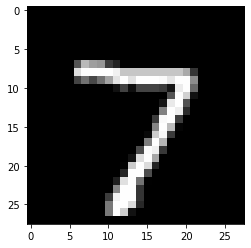

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 0 Predicted: 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


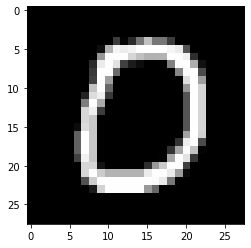

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 9 Predicted: 9


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


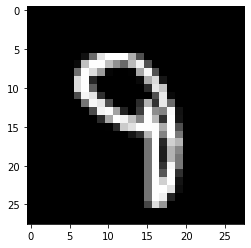

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Label: 2 Predicted: 2


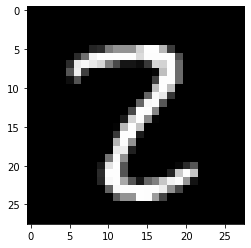

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 2 Predicted: 8


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


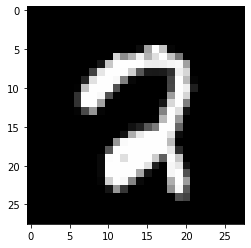

In [ ]:
img, label = test_dataset[119]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 6 Predicted: 6


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


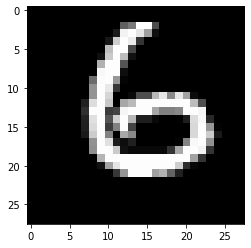

In [ ]:
img, label = test_dataset[1123]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 1 Predicted: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


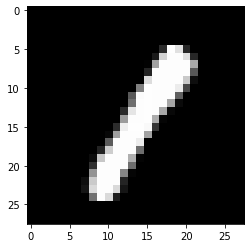

In [ ]:
img, label = test_dataset[7890]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 9 Predicted: 9


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


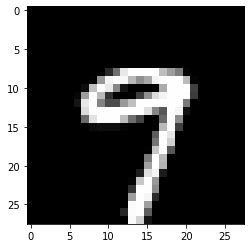

In [ ]:
img, label = test_dataset[1152]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

Label: 4 Predicted: 4


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


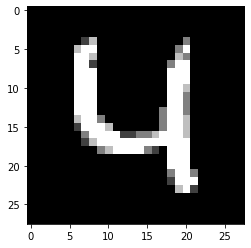

In [ ]:
img, label = test_dataset[2256]
plt.imshow(img[0], cmap='gray')
print('Label:', label, 'Predicted:', predict(img, model))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=200)
final_result = evaluate(model, test_loader)
final_result

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_acc': 0.9487000012397766, 'val_loss': 1.5171948504447936}

In [ ]:
torch.save(model.state_dict(), 'mnist_logistic.pth')

In [ ]:
new_model = MnistModel()

In [ ]:
new_model.state_dict()

OrderedDict([('linear.0.weight',
              tensor([[-0.0266, -0.0075,  0.0196,  ..., -0.0116,  0.0314, -0.0010],
                      [ 0.0310, -0.0283, -0.0088,  ..., -0.0022,  0.0124,  0.0296],
                      [-0.0281, -0.0193, -0.0139,  ...,  0.0261,  0.0100,  0.0082],
                      ...,
                      [-0.0279,  0.0273,  0.0212,  ...,  0.0119,  0.0049, -0.0247],
                      [-0.0298, -0.0203, -0.0239,  ..., -0.0334, -0.0121,  0.0339],
                      [ 0.0209, -0.0249, -0.0058,  ...,  0.0115, -0.0333,  0.0045]])),
             ('linear.0.bias',
              tensor([-0.0349, -0.0180, -0.0015,  0.0352, -0.0281,  0.0175,  0.0240,  0.0233,
                       0.0197, -0.0071,  0.0027, -0.0090,  0.0021,  0.0233,  0.0014,  0.0292,
                       0.0264,  0.0293, -0.0335, -0.0142,  0.0112, -0.0070,  0.0160, -0.0117,
                       0.0104,  0.0121,  0.0221, -0.0031, -0.0256, -0.0332, -0.0126, -0.0208,
                       0.0

In [ ]:
evaluate(new_model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_acc': 0.1051999993622303, 'val_loss': 2.303934907913208}

In [ ]:
new_model.load_state_dict(torch.load('mnist_logistic.pth'))
new_model.state_dict()

OrderedDict([('linear.0.weight',
              tensor([[ 0.0269,  0.0046, -0.0121,  ..., -0.0286, -0.0049, -0.0307],
                      [ 0.0019, -0.0040, -0.0229,  ..., -0.0154, -0.0135, -0.0044],
                      [-0.0214,  0.0356, -0.0356,  ..., -0.0193,  0.0067,  0.0167],
                      ...,
                      [-0.0034, -0.0153,  0.0185,  ..., -0.0231, -0.0164,  0.0217],
                      [-0.0050,  0.0316,  0.0042,  ...,  0.0039, -0.0051, -0.0061],
                      [ 0.0057,  0.0210, -0.0353,  ..., -0.0122,  0.0013, -0.0296]])),
             ('linear.0.bias',
              tensor([-2.9889e-02,  7.7113e-02, -5.7927e-02, -1.7048e-01,  2.5951e-02,
                       1.6606e-01, -6.9946e-02,  1.9106e-02,  8.2942e-05,  1.1492e-01,
                       7.1694e-02,  6.5894e-02,  2.5081e-02,  4.4546e-02,  5.8950e-02,
                      -1.1682e-03,  6.0202e-02,  1.7569e-01,  3.1129e-02,  5.3638e-02,
                      -1.0725e-01,  1.3013e-01, -3.332

In [ ]:
evaluate(new_model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


{'val_acc': 0.9487000012397766, 'val_loss': 1.5171948504447936}